# Benchmark: MBR computation

Benchmark comparing Minimum Bounding Rectangle computation across:

* [georust/geo](https://lib.rs/crates/geo) crate
* The [geos C library](https://trac.osgeo.org/geos/), used through high-level Rust bindings via the [geos](https://lib.rs/crates/geos) crate

## Benchmarked operation

Each iteration computes the Minimum Bounding Rectangle of the multi-polygon representing all districts of India a 100,000 times.

# Prerequisites

Generate data:

```sh
cd harness
cargo run --release --bin benchmark_mbr -- --out-file ../analysis/benchmark_mbr/data.json --geojson-file ../data/india_districts/polbnda_ind.geojson
```

### Loading data from /mnt/data/source/explore-georust/analysis/benchmark_mbr/data.json
### Statistics: Raw data
        duration.total_ms            
program               geo        geos
count          200.000000  200.000000
mean           180.708514   18.183269
std             10.716023    1.937986
min            171.714326   16.946601
25%            175.972184   17.636868
50%            176.944975   17.882002
75%            179.522183   18.050477
max            233.837830   37.779251


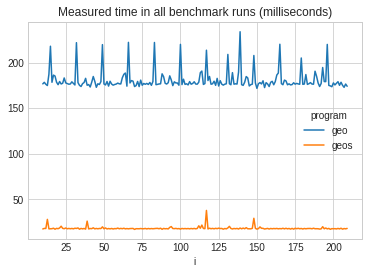

### Statistics: After outlier removal
        duration.total_ms            
program               geo        geos
count          185.000000  185.000000
mean           178.155707   17.930253
std              3.964967    0.612669
min            171.714326   16.946601
25%            175.949732   17.636394
50%            176.802426   17.873143
75%            179.133272   18.041849
max            194.602951   21.700512


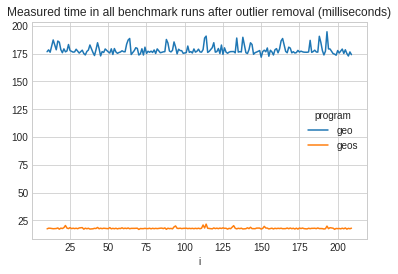

## Absolute difference in runtimes compared to geo
        difference_ms
program          geos
count      185.000000
mean      -160.225453
std          3.881214
min       -174.691200
25%       -161.090376
50%       -159.049028
75%       -158.019043
max       -154.454944


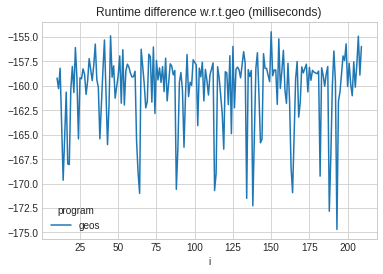

## Relative difference (percent) in runtimes compared to geo
        relative_difference_percent
program                        geos
count                    185.000000
mean                     -89.932387
std                        0.361436
min                      -90.903072
25%                      -90.101308
50%                      -89.948756
75%                      -89.775490
max                      -88.284681


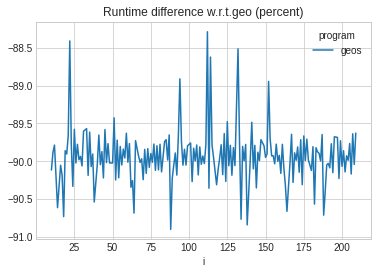

In [3]:
import os
data_absolute_path = os.path.join(os.getcwd(), 'data.json')
%run ../common/benchmark_analysis.ipynb